In [1]:
%matplotlib inline
import loompy
import logging
import pandas as pd
import numpy as np
import cytograph as cg
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import *
from sklearn.metrics.pairwise import cosine_distances
import numpy_groupies as npg
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sparse
import networkx as nx
import community
from sklearn.manifold import TSNE
import umap

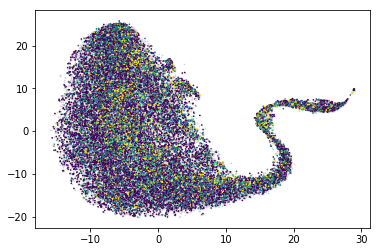

In [2]:
with loompy.connect("/Users/stelin/L1_OligoPons.loom") as ds:
    gene = "Sox10"
    plt.scatter(ds.ca._X,ds.ca._Y,s=10,lw=0,marker='.',c="lightgrey")
    cells = ds[ds.ra.Gene == gene, :][0] > 0
    color = ds[ds.ra.Gene == gene, :][0][cells]
    plt.scatter(ds.ca._X[cells],ds.ca._Y[cells],s=10,lw=0,vmax=np.percentile(color, 95),marker='.',c=color)


In [3]:
celltypes = ["OPC", "COP1", "COP2", "NFOL1", "NFOL2", "MFOL1", "MFOL2", "MOL1", "MOL2", "MOL3"]
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    genes = []
    for ct in celltypes:
        ix = np.where(ds.ca.ClusterName == ct)[0]
        enrichment = ds["enrichment"][:, ix][:,0]
        genes += list(np.argsort(-enrichment)[:400])
    genes = np.sort(ds.ra.Gene[np.unique(genes)])


In [4]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gene_ids = np.where(np.isin(ds.ra.Gene, genes))[0]
    genes = ds.ra.Gene[gene_ids]
    data = ds[gene_ids, :]

In [5]:
N = data.shape[1]
d = []
j = 8989
for ix in range(N):
    d.append(cg.audic_claverie_distance(data[:, j].astype("float64"), data[:, ix].astype("float64")))
d = np.array(d)

12750


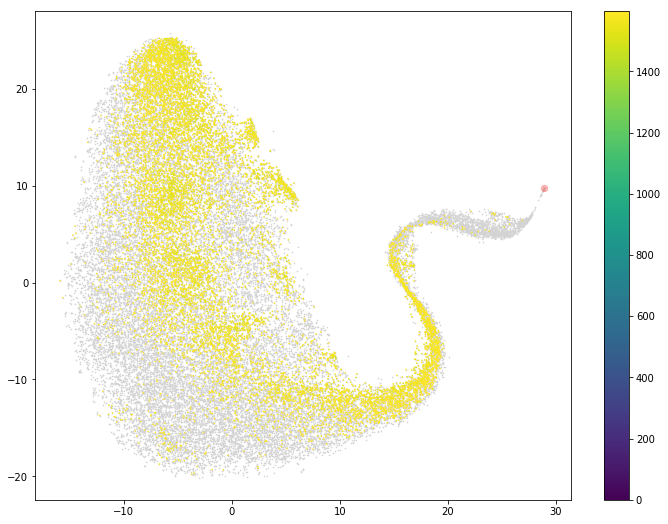

In [10]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(12,9))
    ax = plt.axes()
    plt.scatter(ds.ca._X,ds.ca._Y,s=10,lw=0,marker='.',c="lightgrey")
    cells = d < 1600
    cax=plt.scatter(ds.ca._X[:N][cells],ds.ca._Y[:N][cells],s=10,vmin=0,cmap="viridis",lw=0,marker='.',c=d[cells])
    plt.scatter(ds.ca._X[j],ds.ca._Y[j],s=40,c="red",alpha=0.25)
    plt.colorbar(cax)
    print(cells.sum())

In [8]:
%%time
STEP = 8
d = data[:, ::STEP].transpose()
am = cg.AbsoluteManifold(radius=1.5)
am.fit(d)

/Users/sten/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


CPU times: user 44min 44s, sys: 8.09 s, total: 44min 52s
Wall time: 45min


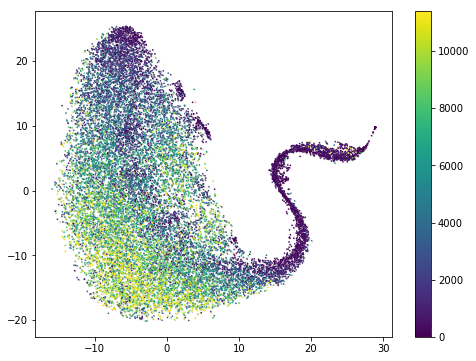

In [9]:
N = d.shape[0]
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    plt.figure(figsize=(8,6))
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,vmin=0,vmax=np.percentile(am.n_neighbors, 95),cmap="viridis",lw=0,marker='.',c=am.n_neighbors)
    plt.colorbar(cax)

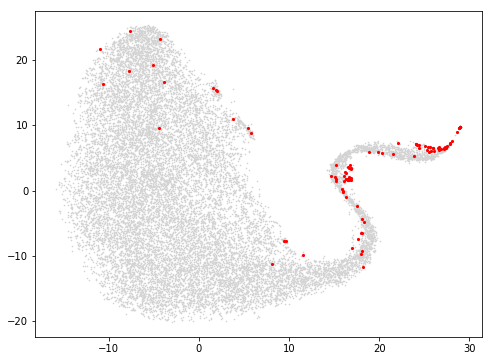

In [10]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    sample = am.outliers()
    plt.scatter(ds.ca._X[::STEP][sample],ds.ca._Y[::STEP][sample],s=40,vmin=0,cmap="viridis",lw=0,marker='.',c='red')

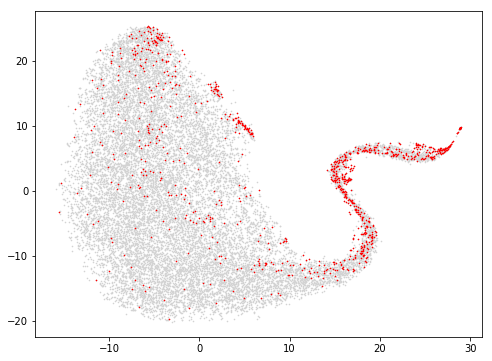

In [11]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    sample = am.sample(N=1000, pseudocounts=10)
    plt.scatter(ds.ca._X[::STEP][sample],ds.ca._Y[::STEP][sample],s=10,vmin=0,cmap="viridis",lw=0,marker='.',c='red')

In [12]:
smoothened = am.smoothen(normalize=True)

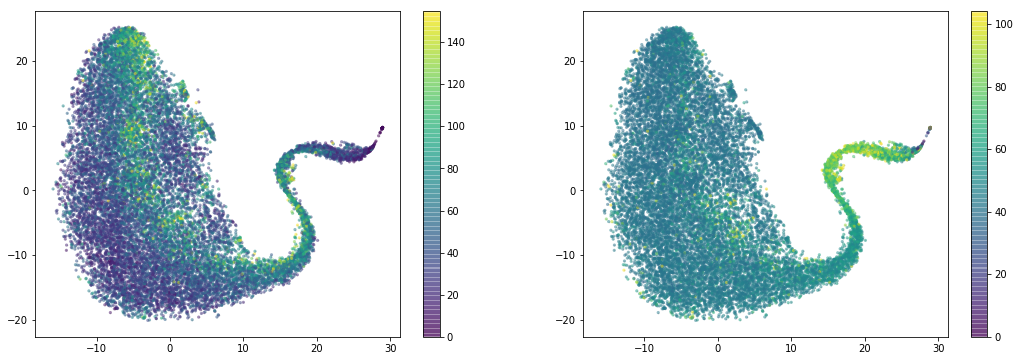

In [13]:
gene = "Mbp"
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(am.data[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=am.data[:,gix])
    plt.colorbar(cax)
    
    plt.subplot(1,2,2)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(smoothened[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=smoothened[:,gix])
    plt.colorbar(cax)

In [16]:
selected = np.sort(am.sample(N=7000))
xy = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      n_components=2,
                      metric=cg.poisson_distance).fit_transform(am.smoothen(normalize=True)[selected,:])

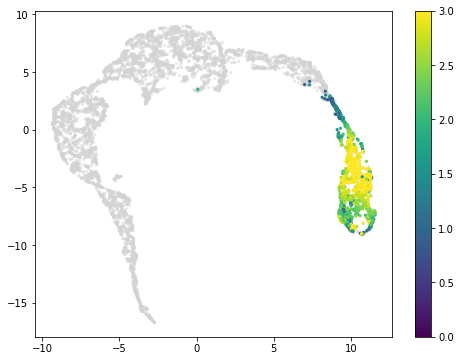

In [17]:
gene = "Itpr2"
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(8,6))
    plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,lw=0,marker='.',
                    c="lightgrey")

    cells = smoothened[:,gix][selected] > 0.8
    cax=plt.scatter(xy[:,0][cells],xy[:,1][cells],s=40,alpha=1,vmin=0,vmax=np.percentile(am.data[:,gix][selected],95),cmap="viridis",lw=0,marker='.',
                    c=smoothened[:,gix][selected][cells])
    plt.colorbar(cax)

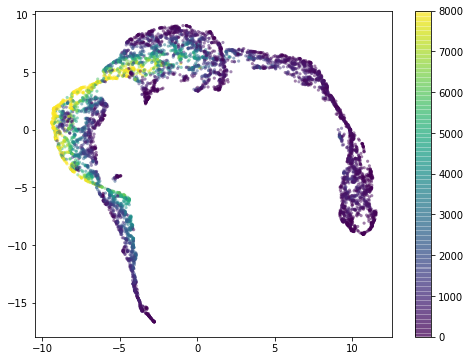

In [18]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=8000,cmap="viridis",lw=0,marker='.',c=am.n_neighbors[selected])
plt.colorbar(cax)

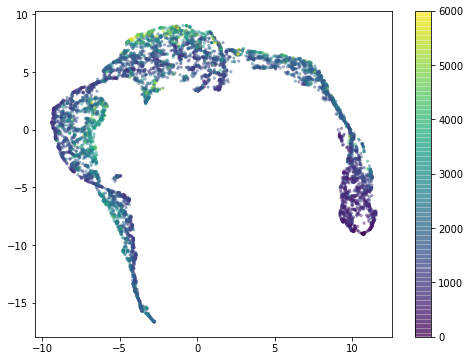

In [19]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=6000,cmap="viridis",lw=0,marker='.',c=am.data.sum(axis=1)[selected])
plt.colorbar(cax)